In [ ]:
import pandas as pd
import numpy as np

from os import path
import os, zipfile
import matplotlib.pyplot as plt
import seaborn as sns

from datetime import datetime
from ipywidgets import Button, HBox, VBox
import ipywidgets as widgets
from IPython.display import FileLink, FileLinks
from IPython.display import display, clear_output

# 1. Make sure to upload your `endlessdice-201903.zip` to root folder in Google Drive.
1. Download from Victor's email chain.
2. Go to Google Drive
3. New+ -> File upload -> *upload the file* `endlessdice-201903.zip`

#### NOTE: only run the following cell once, if you hit an error, you have to hit Runtime -> Factory Reset Runtime
1. It will ask for a link, make sure to accept with the google drive you uploaded the zip to.
2. Hit accept, copy the pass-string, then copy it back to the notebook.

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive', force_remount=True)
%cd gdrive/'My Drive'

2. Import Data to Colab, just run the cell. It will take a while

In [ ]:
def clean_file(file):
    # the current version of clean_file only checks for 
    banks = ['eossuperplay', 'endlessbank1', 'endlessdicex', 'endlesscrash']
    inspect = pd.read_json(file, lines=True)
    inspect['auth_actor'] = inspect['authorization'].apply(lambda x: x[0]['actor'])
    inspect['auth_perm'] = inspect['authorization'].apply(lambda x: x[0]['permission'])
    inspect = inspect.drop(columns=['authorization'])
    inspect = inspect[~inspect['d_to'].isin(banks)]
    return inspect

def summary(data):
    for col in data.columns:
        print(col)
        display(data[col].value_counts())
        print('\n')

archive = zipfile.ZipFile('endlessdice-201903.zip', 'r')

# num_want is now many we want for now
num_files, num_want = len(archive.namelist()), 20
num_want = num_files

combined = clean_file(archive.open(archive.namelist()[0]))
for i, name in enumerate(archive.namelist()[1:]):
    j = i + 1
    if j % 10 == 1: 
        print("{} / {}".format(j, num_want + 1))
        print(name)
    if j > num_want:
        break
    temp = clean_file(archive.open(name))
    combined = combined.append(temp)
print("finished")

temporal = combined[['d_to', 'trx_timestamp']].rename(columns={'d_to': 'user', 'trx_timestamp': 'time'})
temporal['time'] = pd.to_datetime(temporal['time'])
temporal['weekday'] = temporal['time'].dt.weekday
temporal['hour'] = temporal['time'].dt.hour
temporal.head()

1 / 63
actions-endlessbank1-20190302.json
11 / 63
actions-endlessbank1-20190312.json
21 / 63
actions-endlessbank1-20190322.json
31 / 63
actions-endlessdicex-20190301.json
41 / 63
actions-endlessdicex-20190311.json
51 / 63
actions-endlessdicex-20190321.json
61 / 63
actions-endlessdicex-20190331.json
finished


,user,time,weekday,hour
1,nmslnmslnmsl,2019-03-01 00:00:00,4,0
3,justiceariel,2019-03-01 00:00:03,4,0
5,edgarwinston,2019-03-01 00:00:08,4,0
9,raidenkeegan,2019-03-01 00:00:11,4,0
11,nmslnmslnmsl,2019-03-01 00:00:11,4,0


In [ ]:
temporal.to_csv('temporal-only.csv', index=False, header=False)

Ignore this. This just filters some entries based on a limit, which we currently only set to 1 because clearly if someone makes only one transaction, we have no information.

In [ ]:
obvious_bots = pd.read_csv('https://raw.githubusercontent.com/griffinbaum22/bot_detection/main/obvious_bots').obvious_bots.values
len(obvious_bots)

988

In [ ]:
limit = 1

only_once = temporal.groupby('user').agg('count')[['time']]
display(temporal)
only_once = only_once[only_once['time'] <= limit].index

temporal = temporal[~temporal['user'].isin(only_once)]
times = temporal['time']
obvious_bots = pd.read_csv('https://raw.githubusercontent.com/griffinbaum22/bot_detection/main/obvious_bots').obvious_bots.values
# temporal = temporal[~temporal['user'].isin(obvious_bots)]

,user,time,weekday,hour
1,nmslnmslnmsl,2019-03-01 00:00:00.000,4,0
3,justiceariel,2019-03-01 00:00:03.000,4,0
5,edgarwinston,2019-03-01 00:00:08.000,4,0
9,raidenkeegan,2019-03-01 00:00:11.000,4,0
11,nmslnmslnmsl,2019-03-01 00:00:11.000,4,0
...,...,...,...,...
90274,endlessoptex,2019-03-31 23:59:57.500,6,23
90276,endlessdivdn,2019-03-31 23:59:57.500,6,23
90277,endlessoptex,2019-03-31 23:59:57.500,6,23
90279,endlessdivdn,2019-03-31 23:59:58.000,6,23


Make sure the visualize function displays something normal. If it does, then everything is set up properly.

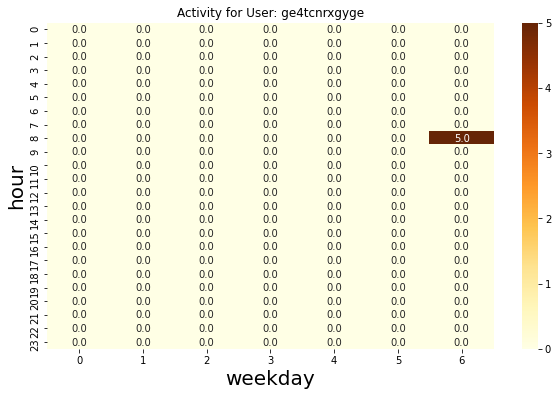

In [ ]:
template = temporal[temporal['user'] == 'nmslnmslnmsl'].groupby(['weekday', 'hour']).agg('count')[['time']]
template['time'] = 0
def visualize_activity(user, center='mean', figsize=(10,6)):
    if user not in set(temporal['user']):
        print('{} DOES NOT EXIST'.format(user))
        return

    # pivot data, there are entries that are empty for now
    pivot_temp = temporal[temporal['user'] == user].groupby(['weekday', 'hour']).agg('count')[['time']]

    # we use nmslnmslnmsl as template since it has entry at every hour, merging with pivot data
    # template = temporal[temporal['user'] == 'nmslnmslnmsl'].groupby(['weekday', 'hour']).agg('count')[['time']]
    template_copy = template.copy()
    template_copy['time'] = pivot_temp['time']
    pivot_temp = template_copy.fillna(0)

    # set mins and max
    min_pivot, max_pivot = min(pivot_temp['time']), max(pivot_temp['time'])

    # plot setting
    pivot_temp = pd.pivot_table(data=pivot_temp,
                                index='hour',
                                columns='weekday',
                                values='time')
    plt.figure(figsize=figsize)
    ax = sns.heatmap(pivot_temp, vmin=min_pivot, vmax=max_pivot,
                    cmap = "YlOrBr",
                    annot=True, fmt=".1f")
    
    # label
    plt.title("Activity for User: {}".format(user))
    ax.set_xlabel('weekday').set_size(20)
    ax.set_ylabel('hour').set_size(20)

sample_name = 'ge4tcnrxgyge'
visualize_activity(sample_name)

In [ ]:
import pickle
def convert_label(i):
    if i == 0:
        return 'bot'
    return 'human'
research_labels = pickle.load(open("groundTruth.pkl", "rb"))
research_labels['research'] = research_labels['label'].apply(convert_label)
research_labels = research_labels[['name', 'research']]
research_labels

,name,research
0,linhuoyaneos,bot
1,g44dambxhage,bot
2,gm2dkmjtguge,bot
3,haydsnbugage,bot
4,gnb4pxctxnes,human
...,...,...
293765,pbufsvyruirs,human
293766,haytaobwgmge,bot
293767,qu2hp3mx4mte,bot
293768,gm3tenbwgqge,bot


Griffinhamza DOES NOT EXIST
jacksonjimmy DOES NOT EXIST
powellernest DOES NOT EXIST
2rezoaf4bhly DOES NOT EXIST
scottphillip DOES NOT EXIST
oepa252sdx4p DOES NOT EXIST
myh2o4wayvxg DOES NOT EXIST


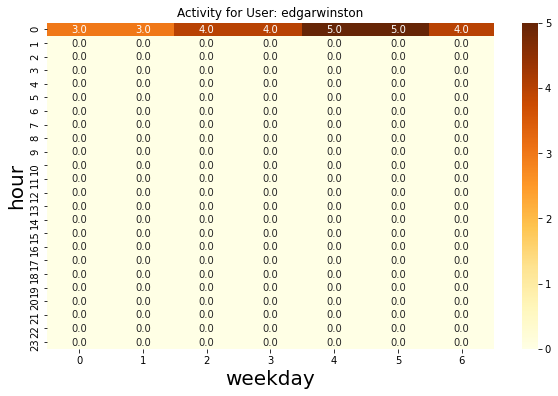

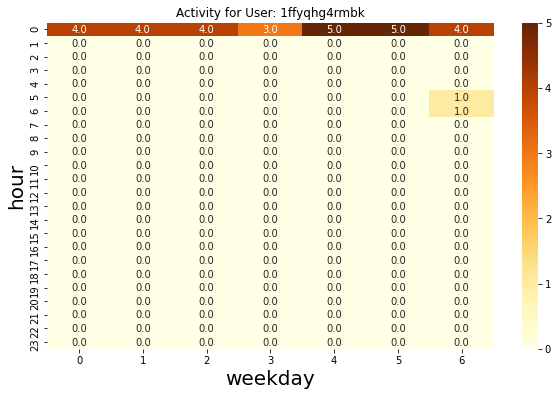

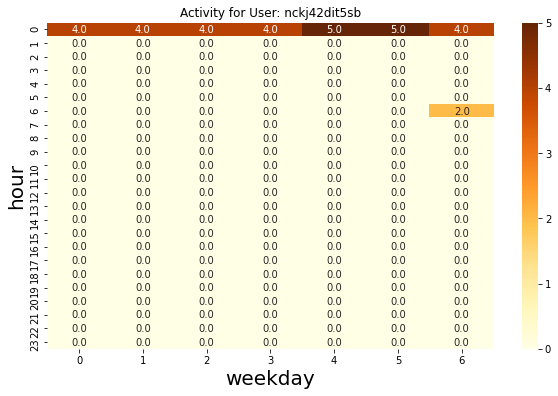

In [ ]:
bots = ['edgarwinston',
        'Griffinhamza',
        'jacksonjimmy',
        '1ffyqhg4rmbk',
        'powellernest',
        '2rezoaf4bhly',
        'nckj42dit5sb',
        'scottphillip',
        'oepa252sdx4p',
        'myh2o4wayvxg']
for bot in bots:
    visualize_activity(bot)

#Important: Change your name from `alan` to your lower-case name

In [ ]:
name = 'alan'

This cell will automatically import any previously labelled data from `alan_labels.csv` in the same Google Drive. Assuming you successfully imported earlier, this should work

In [ ]:
csv_name = name + "_labels.csv"
# do not change this line
if path.exists(csv_name):
    label_df = pd.read_csv(csv_name, names=['name', 'user', 'time', 'label'])
else:
    label_df = pd.DataFrame(columns=['name', 'user', 'time', 'label'])
    
print("This is the last 5 datapoints you labelled!")
display(label_df.tail())

This is the last 5 datapoints you labelled!


,name,user,time,label
18,alan,kzcjigswqx5g,2020-10-23 21:47:56.806619,bot
19,alan,hwiyeong1234,2020-10-23 21:48:26.024492,human
20,alan,x54hucxpjxnp,2020-10-23 21:48:51.875438,bot
21,alan,w2hfwswlfj5x,2020-10-23 21:52:25.328244,bot
22,alan,tduokll4tqy2,2020-10-27 23:39:21.421277,bot


Code for labelling widgets. Don't change

In [ ]:
bot_button = widgets.Button(description="BOT")
hum_button = widgets.Button(description="HUMAN")
bac_button = widgets.Button(description="BACKTRACK")

user = 'nmslnmslnmsl'

def suggest_user():
    global user
    user = np.random.choice(list(set(temporal['user'])))

def write_entry(user, decision):
    num_rows = label_df.shape[0]
    label_df.loc[num_rows] = [name, user, datetime.now(), decision]

def bot_classified(b):
    clear_output(wait=False)
    write_entry(user, 'bot')
    display(label_df.tail(1))
    
    display("Classified as Bot: {}".format(user))
    suggest_user()
    display("current user = {}".format(user))
    visualize_activity(user)
    display(HBox([bot_button, hum_button, bac_button]))
    
def human_classified(b):
    clear_output(wait=False)
    write_entry(user, 'human')
    display(label_df.tail(1))
    
    display("Classified as Human: {}".format(user))
    suggest_user()
    display("current user = {}".format(user))
    visualize_activity(user)
    display(HBox([bot_button, hum_button, bac_button]))
    
def drop_row(b):
    clear_output(wait=False)
    label_df.drop(label_df.tail(1).index,inplace=True)
    display(label_df.tail(1))
    
    display("BACKTRACKED: DELETED USER LAST ENTERED".format(user))
    suggest_user()
    display("current user = {}".format(user))
    visualize_activity(user)
    display(HBox([bot_button, hum_button, bac_button]))
    
bot_button.on_click(bot_classified)
hum_button.on_click(human_classified)
bac_button.on_click(drop_row)

# Your Task: Label Data Here. 
# Ideally at least 200-300 entries since we want to use majority vote from members.
1. You only need to run the cell once.
2. Click `BOT` or `HUMAN` to label the `current user`
3. After you click, the next user to label will be automatically loaded. You should also be able your last entry label.
4. If you misclassified, hit `BACKTRACK`. You will not get the same user when you hit `BACKTRACK` though.

### Important: 
1. If you are not sure if it is a bot, just make a good guess. 
2. Sometimes there are information online, so you can copy the name from Python output to Google and search it up.
3. Sometimes users aren't in the same time zone, so they could be active "at night"

**It is much more important to have correctly labeled data than more data.**


,name,user,time,label
23,alan,jonasgilbert,2020-11-01 00:36:28.432839,bot


'BACKTRACKED: DELETED USER LAST ENTERED'

'current user = nxzbf3fz4brb'

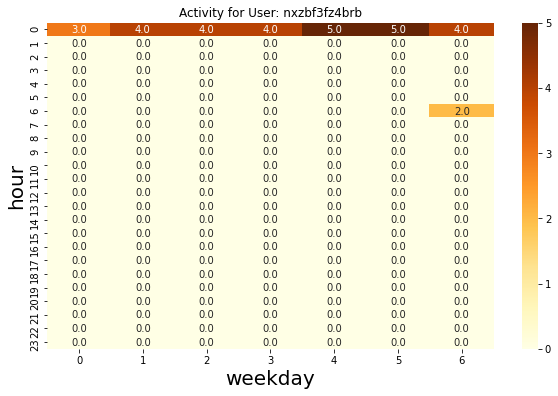

In [ ]:
suggest_user()
display(label_df.tail(1))
visualize_activity(user)
display(HBox([bot_button, hum_button, bac_button]))

In [ ]:
label_df.tail(10)

,name,user,time,label
13,alan,ggzl52oalczi,2020-10-23 21:45:33.972489,bot
14,alan,mnemypndnhoi,2020-10-23 21:45:38.459392,bot
15,alan,broganalexis,2020-10-23 21:45:42.654385,bot
16,alan,3kt4brpbcs4f,2020-10-23 21:45:46.719310,bot
17,alan,kangabieosid,2020-10-23 21:47:52.735676,bot
18,alan,kzcjigswqx5g,2020-10-23 21:47:56.806619,bot
19,alan,hwiyeong1234,2020-10-23 21:48:26.024492,human
20,alan,x54hucxpjxnp,2020-10-23 21:48:51.875438,bot
21,alan,w2hfwswlfj5x,2020-10-23 21:52:25.328244,bot
22,alan,tduokll4tqy2,2020-10-27 23:39:21.421277,bot


# Important: Saving it to a `csv`.
You can find the csv by searching `yourname_labeled.csv` in Google Drive. By next meeting, send the file to our Slack where we will combine it with other members.

In [ ]:
label_df.to_csv(csv_name, index=False, header=False)
# FileLink(csv_name) ignore this

Uploading DataFrame of User Feature Data

In [ ]:
user_df = pd.read_csv('https://raw.githubusercontent.com/griffinbaum22/bot_detection/main/user_df')
user_df

,Unnamed: 0,name,total_trxs,total_wins,win_ratio,total_bet,total_recieved,net_profit,days_active,unique_hrs_active,avg_hrs_active,avg_bet_size
0,0,mehmetfatihu,1,0.0,0.000000,0.1000,0.000000,-0.100000,1,1,1.000000,0.100000
1,1,helloluyh123,1,1.0,1.000000,0.0001,0.000103,0.000003,1,1,1.000000,0.000100
2,2,prahuang5325,1,1.0,1.000000,0.1000,0.103100,0.003100,1,1,1.000000,0.100000
3,3,playeronetkn,1,0.0,0.000000,108.2898,0.000000,-108.289800,1,1,1.000000,108.289800
4,4,jxjdsidsijsk,1,0.0,0.000000,0.1000,0.000000,-0.100000,1,1,1.000000,0.100000
...,...,...,...,...,...,...,...,...,...,...,...,...
1652,1652,kaidenmatias,14179,13451.0,0.948656,4133.6000,4038.439800,-95.160200,31,24,9.967742,0.296863
1653,1653,thegrintsch1,14983,14259.0,0.951679,2856.3010,2810.120389,-46.180611,9,14,3.333333,0.258182
1654,1654,bimawen11111,17832,11701.0,0.656180,35752.7155,35801.692400,48.976900,11,23,13.454545,1.844233
1655,1655,eossuperplay,202279,192085.0,0.949604,33498.3000,32809.528100,-688.771900,31,24,22.451613,0.154505


Loading list of Obvious Bot Accounts (We don't need to manually label these users)

In [ ]:
obvious_bots = pd.read_csv('https://raw.githubusercontent.com/griffinbaum22/bot_detection/main/obvious_bots').obvious_bots.values
len(obvious_bots)

988